In [2]:
import pkuseg #北大分词包
import numpy as np
import pandas as pd
import collections
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities
import networkx as nx #复杂网络分析库
import os

import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
import graphviz

In [28]:
# # 文本录入
path = "C:/Users/X1Yoga2018/Desktop/LDA/text/" #文件夹目录
files= os.listdir(path) #得到文件夹下的所有文件名称
txts = []
for file in files: #遍历文件夹
    position = path+'\\'+ file #构造绝对路径，"\\"，其中一个'\'为转义符
    # print (position)           
    with open(position, "r",encoding='utf-8') as f:    #打开文件
        data = f.read()   #读取文件
        txts.append(data)
string_data = ','.join(txts)#转化为非数组类型  

path_1 = 'C:/Users/X1Yoga2018/Desktop/LDA/' #C:\Users\X1Yoga2018\Desktop\LDA\
with open(path_1 + 'text.txt', 'w', encoding='utf-8') as t:
    t.write(string_data)


# path = 'C:/Users/X1Yoga2018/Desktop/LDA/' #C:\Users\X1Yoga2018\Desktop\LDA\
with open(path_1 + 'text.txt', 'r', encoding='utf-8') as f:
    text = list(set(list(i.replace('\n', '').replace(' ', '') for i in list(f.readlines()))))

print(text)


['', '极大', '［③ｄ］', '大家', 'maybe', '啷当', '相似', '真正', '\u3000\u3000（七）加强统计监测能力建设。严格实施重点用能单位能源利用状况报告制度，健全能源计量体系，加强重点用能单位能耗在线监测系统建设和应用。完善工业、建筑、交通运输等领域能源消费统计制度和指标体系，探索建立城市基础设施能源消费统计制度。优化污染源统计调查范围，调整污染物统计调查指标和排放计算方法。构建覆盖排污许可持证单位的固定污染源监测体系，加强工业园区污染源监测，推动涉挥发性有机物排放的重点排污单位安装在线监控监测设施。加强统计基层队伍建设，强化统计数据审核，防范统计造假、弄虚作假，提升统计数据质量。（国家统计局、国家发展改革委、生态环境部、工业和信息化部、住房城乡建设部、交通运输部、市场监管总局等按职责分工负责）', '不已', '（二）增强战略储备和应急能力\t', '此地', '某某', '看样子', '重新', '以便', '一、把握能源发展大势，充分认识能源革命紧迫性', '一样', '\u3000\u3000三、推动劳动力要素合理畅通有序流动', '挨个', '\u3000\u3000八、扩大高水平对外开放，推动外贸外资平稳发展', '关于完善能源绿色低碳转型体制机制和政策措施的意见', '［②ａ］', '\u3000\u3000（十七）完善绿色发展能力建设支撑保障。支持环境技术交流与转移基地、绿色技术示范推广基地和绿色科技园区等平台建设，强化科技创新能力保障，加强“一带一路”环境技术交流与转移中心（深圳）示范作用。实施绿色丝路使者计划，加强环境管理人员和专业技术人才互动交流，提升共建“一带一路”国家环保能力和水平。开展共建“一带一路”绿色发展专题培训，提高对共建“一带一路”绿色发展的人才支持力度。建设绿色丝绸之路新型智库，构建共建“一带一路”绿色发展智力支撑体系。', '附件', '不', '单位国内生产总值二氧化碳排放比2005年下降60%－65%，二氧化碳排放2030年左右达到峰值并争取尽早达峰；单位国内生产总值能耗（现价）达到目前世界平均水平，主要工业产品能源效率达到国际领先水平；自主创新能力全面提升，能源科技水平位居世界前列；现代能源市场体制更加成熟完善；能源自给能力保持在较高水平，更好利用国际能源资源；初步构建现代能源体

In [29]:
#创建停用词列表
# def stopwordslist():
#     stopwords = [line.strip() for line in open(path + 'stop_words.txt', 'r', encoding='UTF-8').readlines()]
#     return stopwords

stopwords = [] 
with open(path + 'stop_words.txt', 'r', encoding='UTF-8') as f:
    lines = f.readlines()
    for line in lines:
        stopwords.append(line.strip())
my_stop_words = ['发展','重点','推进','实施','环境部','加快','完善','推动','支持','利用','年内','建立','负责','分工','职责','提升','管理','生态']
stopwords = stopwords + my_stop_words

print(stopwords)


['"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', ']', '_', '}', '·', '×', 'Δ', 'Ψ', 'γ', 'μ', 'φ', 'В', '—', '‘', '’', '“', '”', '℃', 'Ⅲ', '↑', '→', '≈', '①', '②', '③', '④', '⑤', '⑥', '⑦', '⑧', '⑨', '⑩', '■', '▲', '、', '。', '〉', '《', '》', '」', '『', '』', '【', '】', '〔', '〕', '㈧', '一', '上', '下', '不', '与', '且', '个', '临', '为', '乃', '么', '之', '乎', '乘', '也', '了', '于', '些', '亦', '人', '今', '仍', '从', '他', '以', '们', '任', '会', '但', '何', '你', '使', '依', '俺', '倘', '借', '像', '儿', '兮', '其', '内', '再', '冒', '冲', '几', '凡', '凭', '则', '别', '到', '即', '却', '去', '又', '及', '另', '只', '叫', '可', '各', '同', '后', '向', '吓', '吗', '吧', '吱', '呀', '呃', '呕', '呗', '呜', '呢', '呵', '呸', '咋', '和', '咚', '咦', '咧', '咱', '咳', '哇', '哈', '哉', '哎', '哗', '哟', '哦', '哩', '哪', '哼', '唉', '啊', '啐', '啥', '啦', '喂', '喏', '喽', '嗡', '嗬', '嗯', '嗳', '嘎', '嘘', '嘛', '嘻', '嘿', '因', '在', '地', '多', '大', '她', '好', '如', '宁', '它', '对', '将', '小', '尔',

In [30]:
# 定义停词函数 对句子进行中文分词
def seg_depart(sentence):
    # 对文档中的每一行进行中文分词
    seg = pkuseg.pkuseg()
    sentence_depart = seg.cut(sentence)
    # 输出结果为outstr
    outstr = ''
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords and word.__len__()>1:
            if word != '\t':
                outstr += word
                outstr += " "
    return outstr
# 分词后的结果
result_fenci = []
for i in text:
    # print(i)
    if seg_depart(i) != '':
        # print(seg_depart(i))
        result_fenci.append([i, seg_depart(i)])

In [40]:
result_fenci = [i[1].split(' ')[:-1] for i in result_fenci]
print(result_fenci)

[['统计', '监测', '能力', '建设', '单位', '能源', '状况', '报告', '制度', '健全', '能源', '计量', '体系', '单位', '能耗', '在线', '监测', '系统', '建设', '工业', '建筑', '交通', '运输', '领域', '能源', '消费', '统计', '制度', '指标', '体系', '探索', '城市', '基础', '设施', '能源', '消费', '统计', '制度', '优化', '污染源', '统计', '调查', '调整', '污染物', '统计', '调查', '指标', '排放', '计算', '方法', '构建', '覆盖', '排污', '许可', '持证', '单位', '固定', '污染源', '监测', '体系', '工业', '园区', '污染源', '监测', '涉挥', '发性', '有机物', '排放', '排污', '单位', '安装', '在线', '监控', '监测', '设施', '统计', '基层', '队伍', '建设', '强化', '统计', '数据', '审核', '防范', '统计', '造假', '弄虚作假', '统计', '数据', '质量', '国家', '统计局', '国家', '改革委', '工业', '信息化', '住房', '城乡', '建设部', '交通', '运输部', '市场', '监管', '总局'], ['增强', '战略', '储备', '应急', '能力'], ['把握', '能源', '大势', '能源', '革命', '紧迫性'], ['劳动力', '要素', '畅通', '有序', '流动'], ['水平', '对外', '开放', '外贸', '外资', '平稳'], ['能源', '绿色', '低碳', '转型', '体制', '机制', '政策', '措施', '意见'], ['十七', '绿色', '能力', '建设', '支撑', '保障', '环境', '技术', '交流', '转移', '基地', '绿色', '技术', '示范', '推广', '基地', '绿色', '科技', '园区', '平台', '建设', '强化', '科技', '创新', '能力', '保障', '一带', 

In [33]:
id2word = corpora.Dictionary(result_fenci)
# 将字典转换为词袋,为文档中的每一个单词创建唯一的ID
corpus = [id2word.doc2bow(sentence) for sentence in result_fenci]

In [34]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes= 20)
# num_topics：主题数目
# passes：训练伦次
# num_words：每个主题下输出的term的数目

for topic in lda_model.print_topics(num_words = 20):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')


0:
  "规划" (0.021)
  "体系" ( 0.018)
  "法律" ( 0.014)
  "监测" ( 0.014)
  "法规" ( 0.012)
  "评估" ( 0.011)
  "健全" ( 0.011)
  "统计" ( 0.010)
  "国家" ( 0.009)
  "能源" ( 0.009)
  "排放" ( 0.009)
  "工业" ( 0.008)
  "核算" ( 0.007)
  "行业" ( 0.007)
  "综合" ( 0.007)
  "战略" ( 0.007)
  "项目" ( 0.007)
  "碳汇" ( 0.007)
  "部门" ( 0.006)
  "水平"( 0.006)
1:
  "煤炭" (0.017)
  "产能" ( 0.011)
  "改造" ( 0.011)
  "排放" ( 0.010)
  "行业" ( 0.010)
  "工程" ( 0.009)
  "绿色" ( 0.009)
  "保护" ( 0.008)
  "建设" ( 0.008)
  "质量" ( 0.008)
  "低碳" ( 0.008)
  "垃圾" ( 0.008)
  "燃煤" ( 0.008)
  "钢铁" ( 0.008)
  "治理" ( 0.007)
  "污染" ( 0.007)
  "资源" ( 0.007)
  "生活" ( 0.007)
  "控制" ( 0.007)
  "水平"( 0.007)
2:
  "能源" (0.049)
  "建设" ( 0.023)
  "电力" ( 0.022)
  "光伏" ( 0.017)
  "企业" ( 0.016)
  "发电" ( 0.016)
  "系统" ( 0.014)
  "综合" ( 0.010)
  "开发" ( 0.010)
  "机制" ( 0.009)
  "鼓励" ( 0.009)
  "示范" ( 0.009)
  "电网" ( 0.008)
  "基地" ( 0.008)
  "再生" ( 0.008)
  "储能" ( 0.008)
  "智能" ( 0.008)
  "资源" ( 0.007)
  "分布式" ( 0.007)
  "项目"( 0.007)
3:
  "工作" (0.031)
  "目标" ( 0.017)
  

In [35]:
'''
模型复杂度和主题一致性提供了一种方便的方法来判断给定主题模型的好坏程度。
特别是主题一致性得分更有帮助。
'''
# def model():
# Compute Perplexity 模型复杂度
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=result_fenci, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda) # 主题一致性得分

Perplexity:  -7.0323630420656436
Coherence Score:  0.4910930156366538


In [41]:
#寻找LDA的最佳主题数:
coherence_values = []
model_list = []
for num_topics in range(2,41,2):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    # random_state=100,
                    # update_every=1,
                    # chunksize=100,
                    # passes=10,
                    # alpha='auto',
                    # per_word_topics=True
)
    model_list.append(lda_model)
    coherencemodel = CoherenceModel(model=lda_model, texts=result_fenci, dictionary=id2word, coherence='c_v')
    coherence_values.append(round(coherencemodel.get_coherence(),3))


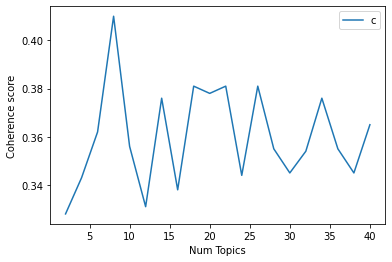

In [42]:
x = range(2,41,2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
#选择具有最高CV的模型，选择的主题数是:
scores = list(zip(x, zip(coherence_values)))
best = sorted(scores, key=lambda i: i[1][0], reverse=True)[0]
print('num of topic: {} based on coherence score({})'.format(best[0],best[1][0]))

num of topic: 8 based on coherence score(0.41)


In [44]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=8, passes= 20)
pprint(lda_model.print_topics(num_words=10))



[(0,
  '0.018*"工作" + 0.015*"能源" + 0.015*"目标" + 0.013*"贯彻" + 0.012*"碳达峰" + '
  '0.012*"试点" + 0.012*"改革" + 0.012*"地区" + 0.012*"中和" + 0.010*"落实"'),
 (1,
  '0.039*"技术" + 0.026*"光伏" + 0.026*"能源" + 0.019*"智能" + 0.016*"建设" + 0.016*"创新" '
  '+ 0.015*"系统" + 0.013*"产业" + 0.013*"电力" + 0.011*"企业"'),
 (2,
  '0.020*"数据" + 0.012*"项目" + 0.011*"探索" + 0.010*"工业" + 0.009*"节能" + 0.008*"设备" '
  '+ 0.007*"煤炭" + 0.007*"领域" + 0.007*"高效" + 0.006*"推广"'),
 (3,
  '0.073*"能源" + 0.015*"消费" + 0.012*"机制" + 0.011*"生产" + 0.011*"市场" + 0.010*"建设" '
  '+ 0.009*"体系" + 0.009*"绿色" + 0.008*"低碳" + 0.008*"提高"'),
 (4,
  '0.018*"部门" + 0.013*"工作" + 0.012*"国务院" + 0.011*"落实" + 0.011*"政策" + '
  '0.009*"监督" + 0.008*"办公厅" + 0.008*"要素" + 0.008*"责任" + 0.008*"群众"'),
 (5,
  '0.036*"国家" + 0.027*"持续" + 0.016*"改革委" + 0.015*"牵头" + 0.012*"政策" + '
  '0.011*"财政部" + 0.009*"建设" + 0.008*"资源" + 0.007*"工业" + 0.007*"企业"'),
 (6,
  '0.035*"节能" + 0.034*"绿色" + 0.021*"建设" + 0.018*"低碳" + 0.017*"交通" + 0.012*"示范" '
  '+ 0.011*"减排" + 0.011*"建筑" + 0.010*"运输" + 0

In [45]:
d=pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = 'pcoa', sort_topics=True)
pyLDAvis.display(d)

C:\Users\X1Yoga2018\AppData\Local\Programs\Python\Python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [46]:

pyLDAvis.save_html(d, 'lda_pass38.html')	# 将结果保存为该html文件